In [1]:
from trainer import *
import cv2

with open('configs/mac_test.yaml') as file:
    config = yaml.full_load(file)
 
trainer = Trainer(config)

Saving checkpoint..
Initializing samples..


In [2]:
dataset = trainer.dataset
s = dataset.__getitem__(10)

array([0.33553426, 0.01814677, 1.10474336])

array([-0.30135079, -0.0188718 , -0.99963057])

In [3]:
def plt_tensor(img, proj_img=False):
    img = (np.transpose(img.cpu().numpy(), (1, 2, 0)))
    
    print(img.shape)
    
    if not proj_img:
        img = 0.5 + (img * 0.5)
    return img

# Create a sample

In [4]:
batch    = next(iter(trainer.train_loader))

In [5]:
tgt        = batch['tgt']
ref_imgs   = batch['ref_imgs']
intrinsics = batch['intrinsics']
poses      = batch['oxts']
depth      = batch['groundtruth']
rect_mat   = batch['rect']

(384, 1280, 3)
(384, 1280, 3)
(384, 1280, 3)


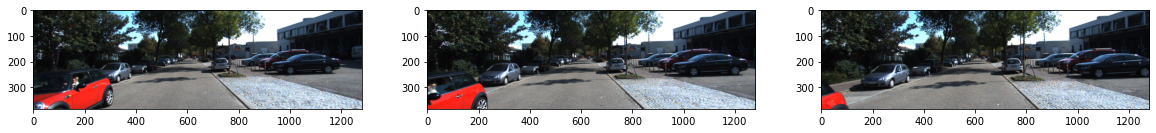

In [13]:
tgt_img = tgt[0]
ref_img = ref_imgs[1][0]
K = intrinsics[0]
rect =  rect_mat[0]

fig, axs = plt.subplots(1, 3, figsize=(20, 20)) 
axs[0].imshow(plt_tensor(ref_imgs[0][0]))
axs[1].imshow(plt_tensor(tgt[0]))
axs[2].imshow(plt_tensor(ref_imgs[1][0]))

In [7]:
from geometry.transform import  Transform
T = Transform()

W = tgt.shape[3]
H = tgt.shape[2]

grid = T.image_grid(1, tgt.shape[2], tgt.shape[3], tgt.dtype, tgt.device)
flat_grid = grid.view(1, 3, -1)  # [B,3,HW]

In [44]:
# convert to cam coords
xnorm = K.inverse().float() @ flat_grid.float()
xnorm = xnorm.view(1, 3, H, W) * depth[0].unsqueeze(0)

In [45]:
# transform to different frame
flat_cam_coords = xnorm.view(1, 3, -1)

rot = torch.eye(3)
t   = poses[1][0][3:].unsqueeze(1)
t   = t/t[2]

Xc = rot.float() @ flat_cam_coords.float()
Xc = Xc + t.float()
Xc = K.float() @ Xc
t

tensor([[0.2827],
        [0.0221],
        [1.0000]], dtype=torch.float64)

In [46]:
# Normalize points
X = Xc[:, 0]
Y = Xc[:, 1]
Z = Xc[:, 2].clamp(min=1e-5)
Xnorm = 2 * (X / Z) / (W - 1) - 1.
Ynorm = 2 * (Y / Z) / (H - 1) - 1.

# Return pixel coordinates
X_grid = torch.stack([Xnorm, Ynorm], dim=-1).view(1, H, W, 2).float()

In [47]:
projected_img = F.grid_sample(ref_img.unsqueeze(0).float(), X_grid, mode='bilinear', padding_mode='zeros', align_corners=True)

(384, 1280, 3)
(384, 1280, 3)
(384, 1280, 3)


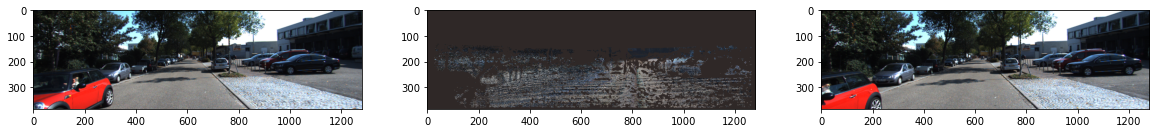

In [48]:
fig, axs = plt.subplots(1, 3, figsize=(20, 20)) 
axs[0].imshow(plt_tensor(ref_imgs[0][0]))
axs[1].imshow(plt_tensor(projected_img[0]))
axs[2].imshow(plt_tensor(tgt[0]))